# Observational study

The goal of the present project is to define a valid metric to evaluate the impact of actors on movies. Specifically, distilling actors careers to a single number, the *star score*. Identifying the latter implies the need to identify truly successful actors, namely actors that had the highest positive impact on movies, in terms of revenues and ratings. Given the presence of multiple confounders, such as the affinity of actors with  particulare genres, different genders or the preference of directors for specific actors, an observational study is carried out to limit the influence of unobserved covariates.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline

import datetime as dt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re
import warnings
warnings.filterwarnings('ignore')

In [9]:
#importing our clean data
data = pd.read_csv('../data/data.csv', index_col = 0)
data_profit = pd.read_csv('../data/profit_data.csv', index_col = 0)
actors = pd.read_csv('../data/timeScores.csv', index_col = 0)
imdb = pd.read_csv('../data/imdb_budgets.csv', index_col = 0)
ss = pd.read_csv('obs.csv', index_col = 0)

In [10]:
usual_suspects = actors.columns.tolist()[1: -2]

def save_values(df, columns):
    
    for col in columns:
        if (col != 'genres'):
            df[col] = df[col].apply(lambda x : x[1:-1].split(' '))
        else:
            df[col] = df[col].apply(lambda x : x.split("\'")[1::2])
    
    return df

timeScores_fixed = save_values(actors,usual_suspects)

In [42]:
actors['appearances'] = ss['appearances']
actors['gender'] = ss['gender']
actors['revenues'] = ss['rev_sum']
actors['ratings'] = ss['grade_sum']
actors['birthdate'] = data['Actor_date_of_birth']

In [45]:
actors['birthdate'] = pd.to_datetime(actors['birthdate']).dt.year

In [46]:
actors.head(3)

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings,star_score,epfl_score,genres,genre_count,main_genre,2nd_genre,appearances,gender,treatment,propensity_score,birthdate
0,Dustin_Farnum,6.117500e+06,[1914.],2.861536,[6117500.],[2.86153647],[16.67802278],[2.69731427],"[Black-and-white, Drama, Indie, Silent film, W...","[1, 1, 1, 1, 1]",Black-and-white,Drama,1.0,M,0,0.818766,1874
1,Elmer_Clifton,1.250000e+09,[1915.],4.791714,[1.25e+09],[4.79171404],[22.51329757],[4.21711313],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama,1.0,M,0,0.956448,1890
2,Robert_Harron,1.250000e+09,[1915.],4.791714,[1.25e+09],[4.79171404],[22.51329757],[4.21711313],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama,1.0,M,0,0.956448,1893


At first, the correlation between budgets and revenues is proved. This will allow us to use revenues as a solid metric for identifying successful actors later on.

Profits are not directly used are a metric for success because of the lack of budget data from the IMDb movie dataset. Anyway, even if direct revenues can slightly influence the outputs, they are not to be ignored, because they provide useful information on movie success and popularity.

In [115]:
#group by movie
budg = data_profit.groupby('Movie_name')['budget','Movie_box_office_revenue'].mean()

Pearson's and Spearman's correlations are used to capture the correlation between the two parameters. It is clear that the is a high linear correlation because of the results shown below.

In [127]:
stats.pearsonr(budg['budget'],budg['Movie_box_office_revenue']) #pearson correlation

PearsonRResult(statistic=0.6579146048455062, pvalue=0.0)

In [124]:
stats.spearmanr(budg['budget'],budg['Movie_box_office_revenue']) #spearman correlation

SpearmanrResult(correlation=0.6470644194502557, pvalue=0.0)

In [130]:
#linear correlation plot (e.g., pearson)
#sns.lmplot('budget','Movie_box_office_revenue', data=budg)

The treatment and control group of the observational study will be identified by the number of times actors starred in movies. The assumption is that successful actors keep acting, while the career of less-successfull ones ends early. This hypothesis is supported by the rich-get-richer mechanism, for which successful actors keep starring with other successful actors, making them even more successful and naturally generating a power law in the appearances distribution.

Just as normal distributions arise from many independent random decisions averaging out, we power laws arise from the feedback introduced by correlated decisions across a population.

Source:
Networks, Crowds, and Markets: Reasoning about a Highly Connected World.
By David Easley and Jon Kleinberg. Cambridge University Press, 2010.
http://www.cs.cornell.edu/home/kleinber/networks-book/

Thedistribution of the number of appearances is shown below. The distribution is a power law because it is represented by a straight line in bi-logarithmic axes (it is linear in the log domain).

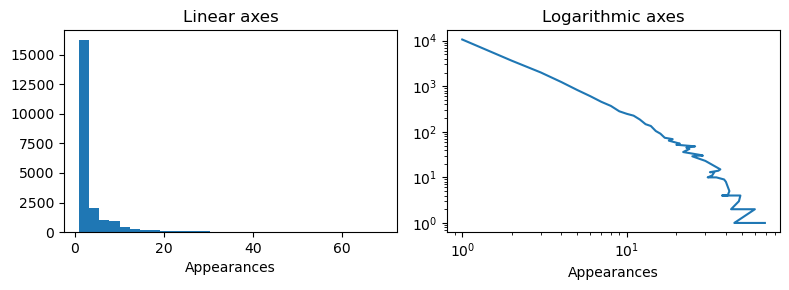

In [47]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

#group by number of appearances and sort
act = actors.groupby('appearances')['appearances'].count().sort_values(ascending=False)

sbplt = ax[0]
sbplt.hist(actors.appearances, bins=30)
sbplt.set_title('Linear axes')
sbplt.set_xlabel('Appearances')

sbplt = ax[1]
sbplt.loglog(act.index,act.values)
sbplt.set_title('Logarithmic axes')
sbplt.set_xlabel('Appearances')
    
fig.tight_layout()
plt.show()

Supported by the previous assumption, the treatment group will be the group with the higher number of appearances. The splitting of the dataset will be carried out based on the median of the distribution, more representative than the mean when considering skewed distributions.

Of course, younger actors may have lower number of appearances only because they are at the beginning of their career. This possible confounder must be considered in the study and the birthdate is taken into account in the propensity score matching.

In [91]:
#median
print('The median of the distribution is ' + str(np.median(actors.appearances)))
print('The mean of the distribution is ' + str(np.mean(actors.appearances)))

The median of the distribution is 2.0
The mean of the distribution is 3.588943623426382


To limit the effect of confounders, the individuals of the groups will be matched on propensity score, namely the probability of being in the treatment group based on observed covariates. Given the extremly large size of the dataset, that would require a heavy computational time for the matching, the actors are first clustered into sub-classes, that differ in terms of the parameters chosen to evaluate movie success (revenues and ratings). Eventually, the original dataset is compared to each of the clusters, to extract the most similar one based on the analysis of the statistics and distributions of the parameters of interest.

In [49]:
#standardization of parameters
Xc = actors[{'revenues','ratings'}]
Xc['revenues'] = Xc['revenues'].apply('log')
Xc['ratings'] = Xc['ratings'].apply('log')
Xc['revenues'] = (Xc['revenues'] - Xc['revenues'].mean())/Xc['revenues'].std()
Xc['ratings'] = (Xc['ratings'] - Xc['ratings'].mean())/Xc['ratings'].std()

At first, the optimal number of clusters has to be identified, bearing in mind that we are not looking for distinct sub-classes, but for a method to simplify the large size of the problem, without compromising the outputs of the study.

In [50]:
actors['treatment'] = (actors['appearances'] > 2).astype(int)

To extract the propensity scores, a logistic regression is trained and applied on the same dataset, this will output the needed probabilities.

In is worth mentioning that the revenues and ratings are characteristics that define the success of the movie and that will set the basis for the definition of the *star score*. Therefore, they are not included in the matching features, otherwise they would bias the process of identification of successful actors.

In [80]:
X = actors[{'main_genre','2nd_genre','gender','birthdate'}]
#X['birthdate'] = (X['birthdate'] - X['birthdate'].mean())/X['birthdate'].std()

In [81]:
X = pd.get_dummies(X,columns=['main_genre','2nd_genre','gender'])
y = actors['treatment']

In [82]:
X.head(3)

,birthdate,main_genre_Absurdism,main_genre_Action,main_genre_Action Comedy,main_genre_Action Thrillers,main_genre_Action/Adventure,main_genre_Addiction Drama,main_genre_Adult,main_genre_Adventure,main_genre_Adventure Comedy,...,2nd_genre_Suspense,2nd_genre_Teen,2nd_genre_Thriller,2nd_genre_Time travel,2nd_genre_War film,2nd_genre_Western,2nd_genre_Workplace Comedy,2nd_genre_World cinema,gender_F,gender_M
0,1874,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1890,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1893,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [83]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='lbfgs', max_iter=100000)
logistic.fit(X,y)

LogisticRegression(max_iter=100000)

In [84]:
actors['propensity_score'] = [i[0] for i in list(logistic.predict_proba(X))]

To further balance the two sub-groups of actors, the process will only match actors of the same gender. Indeed, the gender is a possible confounder for linking the actors to movie success.

Given the extremely large size of the dataset and the matching exponential time needed to minimize the similarity difference between all the possible combinations, the matching is carried out on randomly chosen subsets of the balanced dataset. The statistical significance of the correlation will depend on the resulting p-value, corrected with the Bonferroni correction.

In [85]:
#function to compute similarity (difference between propensity scores to be minimized in the matching)
def get_similarity(prop1,prop2):
    return 1-abs(prop1-prop2)

In [86]:
import networkx as nx

In [89]:
coefficients = []
for i in range(20):
    ran = actors.sample(frac=.01)

    # Create an empty undirected graph
    G = nx.Graph()

    #define treatment and control groups
    treat = ran[ran['appearances'] > 2]
    contr = ran[ran['appearances'] <= 2]

# Loop through all the pairs of instances
    for i, j in contr.iterrows():
        for k, l in treat.iterrows():
            if j['gender'] == l['gender']:
                # Calculate the similarity 
                similarity = get_similarity(j['propensity_score'],
                                            l['propensity_score'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(i, k, similarity)])
                
                # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)] #create list with all indexes of people paired

    balanced_df = actors.loc[matched] #extract only rows with paired subjects
    
    X1 = balanced_df[{'treatment','revenues','ratings'}]
    X1['revenues'] = X1['revenues'].apply('log')
    #X1['ratings'] = X1['ratings'].apply('log')
    X1['revenues'] = (X1['revenues'] - X1['revenues'].mean())/X1['revenues'].std()
    X1['ratings'] = (X1['ratings'] - X1['ratings'].mean())/X1['ratings'].std()
    
    import statsmodels.formula.api as smf
    
    mod = smf.ols(formula='treatment ~ revenues + ratings',
              data=X1)
    res = mod.fit()
    coeff = res.params.values
    p_values = res.pvalues
    
    coefficients.append({"Int": coeff[0], 'p_int': p_values[0], "C1": coeff[1], 'p1': p_values[1], "C2": coeff[2], 'p2': p_values[2]})

The results of the linear regression on the balanced datasets are shown below. In this case, given the number of randomly chosen samples (10), the Bonferroni correction would be given by:

$\alpha = \frac{\alpha_i}{n} = \frac{0.05}{10} = 0.005$

where $\alpha$ is the overall alpha level, $\alpha_i$ are the alpha levels for each hypothesis and $n$ is the number of hypothesis.

From the results, it it possible to observe that there is always a positive correlation with the revenues and a negative correlation with the ratings. However, only the revenues show statistical significance, given that the p-values of all the conducted tests are larger than the imposed threshold.

In [90]:
pd.DataFrame(coefficients)

,Int,p_int,C1,p1,C2,p2
0,0.5,1.067312e-25,0.147387,7.782484e-04,0.000516,0.990440
1,0.5,2.204428e-34,0.195901,1.888063e-07,-0.037370,0.303874
2,0.5,4.426010e-19,0.227237,3.957410e-06,-0.025652,0.582445
3,0.5,7.021170e-29,0.204797,2.009434e-06,-0.089765,0.032166
4,0.5,4.018364e-31,0.183229,6.292460e-06,0.009044,0.818413
5,0.5,1.157181e-28,0.192438,5.423063e-06,-0.072820,0.076969
6,0.5,6.753323e-29,0.266168,1.206724e-10,-0.019784,0.606705
7,0.5,2.209496e-26,0.146146,9.675637e-04,-0.034965,0.422128
8,0.5,1.670983e-22,0.172445,3.303703e-04,-0.015876,0.734574
9,0.5,3.955516e-29,0.186109,1.921517e-05,-0.049192,0.246462


The absence of causality between the movie ratings and the presence of a successful actor can be explained in multiple ways.

+ Usually, the the sequels of movies have lower ratings than the first movies in the saga, while presenting the same cast of actors, therefore, the actor increases his productivity while having a negative impact on movies;

+ High budget movies are related to high revenues, but non necessarily to high movie quality (e.g., Fast&Furious, Sharknado)

PROVE THESE

In [110]:
#imdb[imdb.primaryTitle.apply(lambda x: x.endswith('2'))]

In [138]:
actors

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings,star_score,epfl_score,genres,genre_count,main_genre,2nd_genre,appearances,gender,treatment,propensity_score,birthdate,log_revenue
0,Dustin_Farnum,6.117500e+06,[1914.],2.861536,[6117500.],[2.86153647],[16.67802278],[2.69731427],"[Black-and-white, Drama, Indie, Silent film, W...","[1, 1, 1, 1, 1]",Black-and-white,Drama,1.0,M,0,0.842613,1874,15.626664
1,Elmer_Clifton,1.250000e+09,[1915.],4.791714,[1.25e+09],[4.79171404],[22.51329757],[4.21711313],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama,1.0,M,0,0.970733,1890,20.946409
2,Robert_Harron,1.250000e+09,[1915.],4.791714,[1.25e+09],[4.79171404],[22.51329757],[4.21711313],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama,1.0,M,0,0.970928,1893,20.946409
3,Walter_Long,1.250000e+09,[1915.],4.791714,[1.25e+09],[4.79171404],[22.51329757],[4.21711313],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama,1.0,M,0,0.970004,1879,20.946409
4,Violet_Wilkey,1.250000e+09,[1915.],4.791714,[1.25e+09],[4.79171404],[22.51329757],[4.21711313],"[Black-and-white, Costume drama, Drama, Epic, ...","[1, 1, 1, 1, 1, 1, 1]",Black-and-white,Costume drama,1.0,F,0,0.977766,1903,20.946409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21919,Kathleen_Rose_Perkins,4.254150e+06,[2012.],4.961153,[4254150.],[4.9611535],[16.86504381],[2.74602395],"[Horror, Mystery, Thriller]","[1, 1, 1]",Horror,Mystery,1.0,F,0,0.911404,1977,15.263406
21920,Bo_Barrett,4.254150e+06,[2012.],4.961153,[4254150.],[4.9611535],[16.86504381],[2.74602395],"[Horror, Mystery, Thriller]","[1, 1, 1]",Horror,Mystery,1.0,M,0,0.885598,1963,15.263406
21921,Odeya_Rush,5.256953e+07,[2012.],5.482188,[52569528.125],[5.48218769],[19.47915143],[3.42686897],"[Comedy, Drama, Fantasy]","[1, 1, 1]",Comedy,Drama,1.0,F,0,0.450457,1954,17.777647
21922,Kendall_Ryan_Sanders,5.256953e+07,[2012.],5.482188,[52569528.125],[5.48218769],[19.47915143],[3.42686897],"[Comedy, Drama, Fantasy]","[1, 1, 1]",Comedy,Drama,1.0,M,0,0.385858,1948,17.777647


The *star score* can eventually be defined based on the above analysis.

$star\ score = \left(\bar{A} + 0.2\log{(\bar{R} \cdot)}\right)^{log(\bar{G})}$

where $\bar{A}$ is the average number of appearances of the actor's career and $\bar{G}$, $\bar{R}$ are the averages of the revenues and ratings caused to the movies he starred in. In this case the average is appropriate because the distribution of such parameters in actors careers is not a power law.

The coefficient 0.2 comes from linear correlation coefficient between the log of the revenues and the appearances in previously conducted regression. Indeed, the values of the coefficients oscillate in the neighborhood of 0.2. the ratings are not linearly correlated with the revenues, but still must play a positive role in defining the actor's impact on the movie; the higher the career average ratings, the higher the impact. In this case, the average ratings are logged, namely there is exponent is equal to 1 when the rating is maximum (10), otherwise the star score is reduced because the log of a number between 

We believe this metric includes of the parameters of interest that relate an actor to the success of the movie. 

In [133]:
actors['log_revenue'] = actors['revenues'].apply('log')

In [137]:
actors[actors['appearances'] ==17]

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings,star_score,epfl_score,genres,genre_count,main_genre,2nd_genre,appearances,gender,treatment,propensity_score,birthdate,log_revenue
729,Walter_Pidgeon,7.144082e+07,"[1937., 1938., 1940., 1941., 1942., 1949., 195...",3.872147,"[3.33333333e+07, 5.99500000e+07, 7.13562333e+0...","[, 3.28574518, , 5.79552974, , 8.59054774, 13....","[18.51166192, 19.66610833, 20.23385776, 21.572...","[3.17488607, 3.47556194, 3.62343243, 3.9721816...","[Drama, Romance Film, Musical, Black-and-white...","[13, , 7, , 5, , 4, , 3, , 3, , 3, , 2, , 2, ,...",Drama,Romance Film,17.0,M,1,0.305021,1898,18.084380
1377,Jim_Backus,3.397473e+07,"[1949., 1951., 1951., 1952., 1952., 1952., 195...",3.552366,"[2.62500000e+07, 4.44318182e+07, 5.80681818e+0...","[, 2.68894146, , 6.67079836, 11.04840721, 15.2...","[18.07232415, 19.50720594, 20.2794147, , 20.97...","[3.06046043, 3.43417577, 3.63529774, 3.8169845...","[Comedy, Drama, Romance Film, Black-and-white,...","[9, 6, 5, 5, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, ...",Comedy,Drama,17.0,M,1,0.361076,1902,17.341128
1594,Kevin_McCarthy,3.697219e+07,"[1951., 1954., 1956., 1978., 1978., 1981., 198...",4.309042,"[1.09090909e+07, 3.36363636e+07, 6.09090909e+0...","[, 4.86769236, , 7.84008371, 13.77470833, 19.7...","[17.787727, , , 19.3903678, , 20.54772718, 21....","[2.98633703, 3.40374525, 3.7051798, , 4.038893...","[Comedy, Drama, Indie, Thriller, Parody, Scien...","[9, 7, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, ...",Comedy,Drama,17.0,M,1,0.350519,1882,17.425677
1798,Marlon_Brando,2.902346e+08,"[1951., 1952., 1954., 1954., 1955., 1957., 196...",4.954959,"[7.27272727e+07, 9.00000000e+07, 1.77272727e+0...","[, 6.00346476, 10.62312636, 16.98042333, 20.85...","[19.89456378, 20.67835358, 21.82526105, 22.238...","[3.53506322, 3.73920148, 4.03791383, 4.1454693...","[Drama, Romance Film, Action, Adventure, War f...","[10, , 5, , 4, , 4, , 4, , 4, , 3, , 3, , 3, ,...",Drama,Romance Film,17.0,M,1,0.306488,1901,19.486200
1799,Piper_Laurie,2.865905e+07,"[1951., 1952., 1955., 1957., 1961., 1976., 198...",4.167136,"[2.09090909e+07, 3.22727273e+07, 4.13636364e+0...","[, 2.70801133, , 5.27777517, , 8.33530496, 11....","[17.85190913, 18.95323771, 19.65841281, 20.214...","[3.00305328, 3.2898946, , 3.47355764, 3.618289...","[Drama, Crime Fiction, Indie, Romance Film, Co...","[10, , 4, , 4, , 4, , 3, , 3, , 3, , 3, , 2, ,...",Drama,Crime Fiction,17.0,F,1,0.395014,1910,17.170980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13612,Zoe_Saldana,3.202572e+08,"[2000., 2001., 2002., 2002., 2003., 2004., 200...",5.361242,"[3.66471403e+07, 6.35395268e+07, 1.40324173e+0...","[, 4.67323784, , 9.21002313, 14.12535372, 19.5...","[18.95869811, 20.1874651, , 21.40743715, 22.19...","[3.29131676, 3.61134945, 3.92909149, 4.1331809...","[Drama, Comedy, Action, Romance Film, Thriller...","[9, 8, 7, 6, 6, 5, 4, 4, 3, 3, 3, 3, 2, 2, 2, ...",Drama,Comedy,17.0,F,1,0.229051,1927,19.584635
14033,Conrad_Vernon,6.662999e+08,"[2001., 2003., 2004., 2004., 2005., 2007., 200...",5.435074,"[6.54607051e+08, 7.59500407e+08, 1.92385327e+0...","[, 6.28304222, 11.08012332, 17.2967547, , 23.5...","[22.13739998, 22.85332423, 24.22811482, 25.008...","[4.1192105, , 4.30567316, 4.66373773, 4.866970...","[Animation, Adventure, Comedy, Family Film, s/...","[17, 17, 16, 16, 15, 11, , 9, , 7, , 7, , 6, ,...",Animation,Adventure,17.0,M,1,0.864509,1930,20.317250
14630,Eddie_Marsan,1.887180e+08,"[2002., 2003., 2004., 2005., 2006., 2006., 200...",5.459713,"[2.58363339e+08, 3.36841052e+08, 3.53223098e+0...","[, 6.08530699, 12.15412872, 17.44062982, 22.16...","[21.17575462, 22.13279064, 22.54141295, 22.803...","[3.86874971, 4.11801, , , , 4.22443578, 4.2926...","[Drama, Period piece, Crime Fiction, Thriller,...","[14, , 7, , 6, , 6, , 6, , 5, , 4, , 4, , 4, ,...",Drama,Period piece,17.0,M,1,0.417650,1958,19.055765
15026,Anne_Hathaway,2.720309e+08,"[2002., 2003., 2004., 2005., 2006., 2006., 200...

As a remainder, male actors were matched together, as well as female actresses, because of the will to tackle the possible confounder of gender disparity. A posteriori, it can be verified that the gender does not play a role in the actor's success on the balanced dataset. Two independent tests are carried out on the balanced dataset (investigating revenues and ratings) and the reslts show p-values larger than 0.05, implying the acceptance of the null-hypothesis that the samples have same averages.

Therefore, the confounder was successfully tackled.

In [82]:
df_m = balanced_df[balanced_df['gender'] == 'M']
df_f = balanced_df[balanced_df['gender'] == 'F']

In [83]:
print(stats.ttest_ind(df_m['revenues'], df_f['revenues'])) #independent test
print(stats.ttest_ind(df_m['ratings'], df_f['ratings'])) #independent test

Ttest_indResult(statistic=1.2557731003167656, pvalue=0.2094005573762068)
Ttest_indResult(statistic=0.5487491385163628, pvalue=0.5832621018055049)
